# Metagenomes

This notebook analyzes metagenome-assembled genomes from DOE JGI's GEM dataset. The emphasis is on the distribution of traits across and within habitats.

In [1]:
import datetime
import json
from glob import glob
import sys 
from pathlib import Path
from scipy.cluster.hierarchy import linkage, leaves_list

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from collections import Counter
from matplotlib.colors import LinearSegmentedColormap

sys.path.append("../")
plt.rcParams['svg.fonttype'] = 'none'

plt.style.use('project.mplstyle')

In [3]:
import pandas as pd

def load_predictions_to_dfs(tsv):
    predictions_df = pd.read_csv(tsv, sep='\t', index_col=0)
    return predictions_df

def ravel_dataframe_by_counts(df):
    """Dataframe values are True/False and index is a value"""
    ravel = []
    counts = df.sum(axis=1)
    for x in counts.index:
        count = counts.loc[x]
        ravel.extend([float(x)] * count)
    return ravel

In [4]:
units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% NaCl',
    'oxygen' : 'Prob.'
}

plot_formats = {
    'oxygen' : 'Oxygen',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
    'temperature_min' : 'Temperature, Minimum',
    'salinity_min' : 'Salinity, Minimum',
    'ph_min' : 'pH, Minimum',
    'temperature_max' : 'Temperature, Maximum',
    'salinity_max' : 'Salinity, Maximum',
    'ph_max' : 'pH, Maximum',
}

In [5]:
targets = ['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']

bin_definitions = {
    'oxygen' : [0, 0.5],
    'ph_optimum' : np.arange(3,12,1),
    'temperature_optimum' : [0,15,30,45,60,80],
    'salinity_optimum' : [0, 0.5, 1, 2.5, 5, 10, 15],
}
oxygen_colors = ['dimgray', 'whitesmoke', 'skyblue']
oxygen_colors = ['#0E95C8',   '#F8A483'] #'whitesmoke',
oxygen_colors = [plt.get_cmap("RdBu_r")(0.15),   plt.get_cmap("RdBu_r")(0.83)] # plt.get_cmap("RdBu_r")(0.5),
oxygen_cmap = LinearSegmentedColormap.from_list('my_cmap', oxygen_colors, N=3)

cmap_definitions = {target : plt.get_cmap("RdBu_r") for target in targets}
cmap_definitions['oxygen'] = oxygen_cmap

# Load data

## GEM Metadata

In [118]:
# metadata file is mislabeled relative to paper, so relabeling as best as possible

category_to_biome1 = {'Air': 'Air',
 'Algae': 'Host-associated',
 'Animal': 'Host-associated',
 'Annelida': 'Host-associated',
 'Aquatic': 'Aquatic',
 'Arthropoda': 'Host-associated',
 'Bioreactor': 'Engineered',
 'Bioremediation': 'Engineered',
 'Biotransformation': 'Engineered',
 'Birds': 'Host-associated',
 'Built environment': 'Engineered',
 'Cnidaria': 'Host-associated',
 'Fish': 'Host-associated',
 'Fungi': 'Host-associated',
 'Human': 'Host-associated',
 'Industrial production': 'Engineered',
 'Insecta': 'Host-associated',
 'Invertebrates': 'Host-associated',
 'Lab enrichment': 'Engineered',
 'Lab synthesis': 'Engineered',
 'Mammals': 'Host-associated',
 'Microbial': 'Host-associated',
 'Modeled': 'Engineered',
 'Mollusca': 'Host-associated',
 'Plants': 'Host-associated',
 'Porifera': 'Host-associated',
 'Solid waste': 'Engineered',
 'Terrestrial': 'Terrestrial',
 'Tunicates': 'Host-associated',
 'Wastewater': 'Engineered'}

type_to_biome2 = {
    'Outdoor Air': 'Air',
 'Freshwater': 'Freshwater',
 'Marine': 'Marine',
 'Non-marine Saline and Alkaline': 'Non-marine Saline and Alkaline',
 'Sediment': 'Sediment',
 'Thermal springs': 'Thermal springs',
 'Cave': 'Cave',
 'Deep subsurface': 'Deep subsurface',
 'Geologic': 'Other terrestrial',
 'Oil reservoir': 'Other terrestrial',
 'Peat': 'Peat',
 'Plant litter': 'Plant litter',
 'Rock-dwelling (subaerial biofilms)': 'Other terrestrial',
 'Soil': 'Soil',
 'Volcanic': 'Other terrestrial',
    'Activated Sludge': 'Wastewater',
 'Aerobic': 'Other engineered',
 'Anaerobic': 'Other engineered',
 'Anaerobic digestor': 'Wastewater',
 'City': 'Built environment',
 'Composting': 'Other engineered', 
 'Continuous culture': 'Other engineered', 
 'Defined media': 'Other engineered',
 'Engineered product': 'Other engineered',
 'Hydrocarbon': 'Other engineered', 
 'Industrial wastewater': 'Other engineered', 
 'Landfill': 'Landfill',
 'Microbial enhanced oil recovery': 'Other engineered', 
 'Microbial solubilization of coal': 'Other engineered', 
 'Mixed alcohol bioreactor': 'Other engineered', 
 'Nutrient removal': 'Wastewater',
 'Persistent organic pollutants (POP)': 'Other engineered', 
 'Simulated communities (DNA mixture)': 'Other engineered',
 'Simulated communities (microbial mixture)': 'Other engineered',
 'Solar panel': 'Built environment',
 'Terephthalate': 'Other engineered', 
 'Tetrachloroethylene and derivatives': 'Other engineered', 
 'Water treatment plant': 'Wastewater',
 'Algae': 'Algae',
 'Animal': 'Other host-associated',
 'Annelida': 'Invertebrates',
 'Arthropoda': 'Invertebrates',
 'Birds': 'Vertebrates',
 'Cnidaria': 'Invertebrates',
 'Fish': 'Vertebrates',
 'Fungi': 'Fungi',
 'Human': 'Vertebrates',
 'Insecta': 'Invertebrates',
 'Invertebrates': 'Invertebrates',
 'Mammals': 'Vertebrates',
 'Microbial': 'Other host-associated',
 'Mollusca': 'Invertebrates',
 'Plants': 'Plants',
 'Porifera': 'Invertebrates',
 'Tunicates': 'Invertebrates',
}

ignore_biomes = {'Other host-associated', 'Other terrestrial', 'Air',  'Other aquatic'}


genome_metadata_df = pd.read_csv('/Users/tylerbarnum/cultivarium/external/gem_jgi/genome_metadata.tsv', sep='\t',)
genome_metadata_df = genome_metadata_df.rename(columns={'ecosystem' : 'taxstring'})
genome_metadata_df['biome1'] = genome_metadata_df['ecosystem_category'].map(category_to_biome1)
genome_metadata_df['biome2'] = [''] * len(genome_metadata_df)
for idx in genome_metadata_df.index:
    eco_type = genome_metadata_df.at[idx, 'ecosystem_type']
    eco_cat = genome_metadata_df.at[idx, 'ecosystem_category']
    if eco_type == 'Unclassified':
        genome_metadata_df.at[idx, 'biome2'] = 'Other ' + genome_metadata_df.at[idx, 'biome1'].lower()
    elif eco_type in type_to_biome2.keys():
        genome_metadata_df.at[idx, 'biome2'] = type_to_biome2[eco_type]
    elif eco_cat in type_to_biome2.keys():
        genome_metadata_df.at[idx, 'biome2'] = type_to_biome2[eco_cat]
    else:
        print(eco_cat, eco_type)

genome_metadata_df.head(1)

,genome_id,metagenome_id,genome_length,num_contigs,n50,num_16s,num_5s,num_23s,num_trna,completeness,...,mimag_quality,otu_id,taxstring,ecosystem_category,ecosystem_type,habitat,longitude,latitude,biome1,biome2
0,3300025516_6,3300025516,2910752,137,34707,1.0,1.0,1.0,43.0,90.42,...,HQ,OTU-1761,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,Terrestrial,Deep subsurface,Serpentinite rock and fluid,-122.439,38.874,Terrestrial,Deep subsurface


## Predictions

In [74]:
PATH_TO_PREDICTIONS = "../data/predictions_gem"

def oxygen_value_error_to_prob(value, error):
    """Convert to legacy format for analysis"""
    if value == "tolerant":
        probability = error
    else:
        probability = 1 - error
    return probability

sers = []
for tsv in glob(f"{PATH_TO_PREDICTIONS}/*.predictions.tsv"):
    try:
        predictions_df = pd.read_csv(tsv, sep='\t', index_col=0)
        accession = tsv.split('/')[-1][:-len('.predictions.tsv')]
        value = predictions_df.loc['oxygen', 'value']
        error = predictions_df.loc['oxygen', 'error']
        ser = predictions_df['value']
        ser.at['oxygen'] = oxygen_value_error_to_prob(value, error)
        ser = ser.astype(float)
        ser.name = accession
        sers.append(ser)
    except:
        pass

optima_df = pd.concat(sers,axis=1).T
optima_df

target,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum
3300025640_35,0.957532,9.943997,5.349265,7.478552,3.086731,0.000000,0.000000,29.689803,9.418584,23.889203
3300012847_11,0.971758,8.605819,5.361243,6.928523,2.098983,0.000000,0.000000,35.370597,10.782845,27.788790
3300008660_3,0.067940,9.413505,6.477551,7.807200,9.667497,0.649015,3.946863,40.870916,11.782698,30.327258
3300007802_42,0.005884,8.294718,4.394675,6.525067,5.614853,0.757281,0.096314,46.380725,22.769516,38.978341
3300020477_45,0.959607,9.722181,6.083280,7.835349,13.628693,1.404875,5.320082,40.785372,13.885410,33.285136
...,...,...,...,...,...,...,...,...,...,...
3300012956_46,0.929395,7.923302,5.051979,6.420187,0.815621,0.000000,0.074804,35.108727,9.021477,25.644973
3300012141_10,0.874945,6.955952,5.162601,6.034278,3.979429,0.000000,0.000000,35.650781,7.378633,26.336488
3300025664_18,0.968611,8.727471,4.727015,6.675384,2.938051,0.000000,0.000000,33.215491,7.770932,24.808351
3300025209_1,0.965617,9.763698,5.383612,7.554462,6.263653,0.000000,1.033302,32.021521,10.088294,24.087998


In [123]:
# Save supplementary data

metadata_cols =  ['genome_id', 'metagenome_id', 'ecosystem_category', 'ecosystem_type', 'habitat', ]



mag_table = pd.merge(optima_df, genome_metadata_df[['taxstring'] + metadata_cols].set_index('genome_id'), left_index=True, right_index=True, how='left').reset_index()


taxonomy = pd.DataFrame(mag_table['taxstring'].astype(str).str.split(';').tolist())
taxlevels = ['domain', 'phylum', 'class','order','family','genus','species']
taxonomy.columns = taxlevels
for rank in taxlevels:
    taxonomy[rank] = [str(i).replace(f"{rank[0]}__", "") for i in taxonomy[rank].tolist()]
taxonomy.index = mag_table.index
mag_table = pd.concat([mag_table, taxonomy], axis=1)

cols_to_save = ['oxygen',
 'temperature_optimum',
 'salinity_optimum',
 'ph_optimum',
 'temperature_min',
 'temperature_max',
 'salinity_min',
 'salinity_max',
 'ph_min',
 'ph_max',] + metadata_cols + taxlevels[::-1]

mag_table = mag_table.rename(columns={'index' : 'genome_id'}) #
mag_table = mag_table.loc[:, cols_to_save].set_index('genome_id').sort_values(['ecosystem_category', 'ecosystem_type', 'habitat'] + taxlevels)
mag_table.to_csv('supplementary_data_5.tsv', sep='\t')
mag_table

,oxygen,temperature_optimum,salinity_optimum,ph_optimum,temperature_min,temperature_max,salinity_min,salinity_max,ph_min,ph_max,...,ecosystem_category,ecosystem_type,habitat,species,genus,family,order,class,phylum,domain
genome_id,,,,,,,,,,,,,,,,,,,,,
3300026229_5,0.773373,29.411412,2.543468,5.789336,15.908295,36.395370,1.828083,2.558000,4.212201,7.414375,...,Air,Outdoor Air,Upper troposphere,Cutibacterium acnes,Cutibacterium,Propionibacteriaceae,Propionibacteriales,Actinobacteria,Actinobacteriota,Bacteria
3300026236_4,0.754751,30.936143,2.408356,5.678824,17.808420,37.903971,1.690492,2.347644,4.088667,7.329979,...,Air,Outdoor Air,Upper troposphere,Cutibacterium acnes,Cutibacterium,Propionibacteriaceae,Propionibacteriales,Actinobacteria,Actinobacteriota,Bacteria
3300026233_2,0.977789,33.223070,0.000000,6.404765,17.344565,44.127815,0.000000,1.785854,4.734106,8.805623,...,Air,Outdoor Air,Upper troposphere,,UBA5005,Caulobacteraceae,Caulobacterales,Alphaproteobacteria,Proteobacteria,Bacteria
3300026236_2,0.984544,33.362480,0.000000,6.155939,16.683741,43.885549,0.000000,1.150458,4.582750,8.534947,...,Air,Outdoor Air,Upper troposphere,,UBA5005,Caulobacteraceae,Caulobacterales,Alphaproteobacteria,Proteobacteria,Bacteria
3300026228_3,0.982052,33.023099,0.000000,6.284551,16.565683,43.751988,0.000000,1.326419,4.753592,8.616778,...,Air,Outdoor Air,Upper troposphere,,UBA5005,Caulobacteraceae,Caulobacterales,Alphaproteobacteria,Proteobacteria,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300005676_2,0.971317,30.145278,4.974302,7.043318,22.275719,39.483038,2.508270,8.809191,5.746397,8.749095,...,Wastewater,Nutrient removal,lab-scale EBPR bioreactor,GCA_002434045.1,UBA5946,Saccharimonadaceae,Saccharimonadales,Saccharimonadia,Patescibacteria,Bacteria
3300005680_9,0.972095,28.086813,4.387306,7.193074,19.274107,37.357306,2.060663,8.638345,5.748326,9.054078,...,Wastewater,Nutrient removal,lab-scale EBPR bioreactor,UBA5946 sp1,UBA5946,Saccharimonadaceae,Saccharimonadales,Saccharimonadia,Patescibacteria,Bacteria
3300005673_1,0.856912,29.688764,1.693069,7.164804,13.945382,37.258157,0.432967,4.519089,5.330873,9.157020,...,Wastewater,Nutrient removal,lab-scale EBPR bioreactor,GCA_000585015.1,Accumulibacter,Rhodocyclaceae,Betaproteobacteriales,Gammaproteobacteria,Proteobacteria,Bacteria


In [41]:
missing_genomes = optima_df[optima_df.isnull().sum(axis=1) > 0].index
len(missing_genomes)

53

In [42]:
optima_df = optima_df.dropna()

# Compare metagenomes

In [44]:
MIN_GENOMES_IN_METAGENOME = 5


In [45]:

def compute_stats_by_metagenome(metadata_df, stat, min_genomes=10, targets=['oxygen', 'ph_optimum', 'salinity_optimum', 'temperature_optimum']):
    sers = []
    for metagenome_id, group in metadata_df.groupby('metagenome_id'):
        genome_ids = group['genome_id'].tolist()
        if len(genome_ids) >= min_genomes:
            if stat == 'mean':
                ser = optima_df.reindex(genome_ids)[targets].mean()
            elif stat == 'std':
                ser = optima_df.reindex(genome_ids)[targets].std()
            elif stat == 'min':
                ser = optima_df.reindex(genome_ids)[targets].min()
            elif stat == 'max':
                ser = optima_df.reindex(genome_ids)[targets].max()
                
            ser.name = metagenome_id
            sers.append(ser)
    stats_df = pd.concat(sers,axis=1).T
    stats_df
    return stats_df

def cluster_by_metagenome_mean(zscores, algorithm='complete'):
    Z = linkage(zscores, algorithm)
    order = leaves_list(Z)
    indices = zscores.iloc[order].index
    return indices

def histogram_by_values(value_df, genome_ids, target, bins):
    values = optima_df.reindex(genome_ids)[target].dropna()
    # hack to fix bad values currently.
    values.loc[values < bins[0]] = bins[0]
    # 
    binned_values = np.digitize(values, bins)
    binned_ser = pd.Series(Counter(binned_values))
    binned_ser.name = target
    return binned_ser


def newline_if_long(text, pad_newlines=0):
    
    if len(text) > 25:
        left_splits = []
        right_splits = []
        for word in text.split(' '):
            if len(left_splits) == 0:
                left_splits.append(word)
            elif len(' '.join(left_splits)) < (len(text) / 2):
                left_splits.append(word)
            else:
                right_splits.append(word)
        new_text = ' '.join(left_splits + ['']*pad_newlines) + '\n' + ' '.join(right_splits+ ['']*pad_newlines)
        return new_text
    else:
        return text +  ' '.join(['']*pad_newlines)

# Compute stats and cluster

means_df = compute_stats_by_metagenome(genome_metadata_df, stat='mean', min_genomes=MIN_GENOMES_IN_METAGENOME)
mins_df = compute_stats_by_metagenome(genome_metadata_df, stat='min', min_genomes=MIN_GENOMES_IN_METAGENOME)
maxs_df = compute_stats_by_metagenome(genome_metadata_df, stat='max', min_genomes=MIN_GENOMES_IN_METAGENOME)
diffs_df = maxs_df - mins_df
stds_df = compute_stats_by_metagenome(genome_metadata_df, stat='std', min_genomes=MIN_GENOMES_IN_METAGENOME)
zscores_df = ((means_df - means_df.mean(axis=0)) / means_df.std(axis=0))
indices = cluster_by_metagenome_mean(means_df)


In [46]:
print(f"# metagenomes used {len(indices)}/{len(genome_metadata_df['metagenome_id'].drop_duplicates())}")

# metagenomes used 3407/7304


In [47]:
# Fractopm of data in each biome
genome_metadata_df[genome_metadata_df['metagenome_id'].isin(indices)].drop_duplicates(subset=['metagenome_id'])['biome2'].value_counts() / len(indices)

biome2
Vertebrates                       0.368946
Marine                            0.203698
Freshwater                        0.118286
Other engineered                  0.050484
Soil                              0.050191
Non-marine Saline and Alkaline    0.036983
Wastewater                        0.033754
Plants                            0.030232
Built environment                 0.027884
Invertebrates                     0.024949
Thermal springs                   0.016143
Other host-associated             0.011447
Deep subsurface                   0.009392
Fungi                             0.006164
Algae                             0.003816
Other aquatic                     0.002348
Landfill                          0.002055
Sediment                          0.000881
Cave                              0.000881
Other terrestrial                 0.000881
Peat                              0.000587
Name: count, dtype: float64

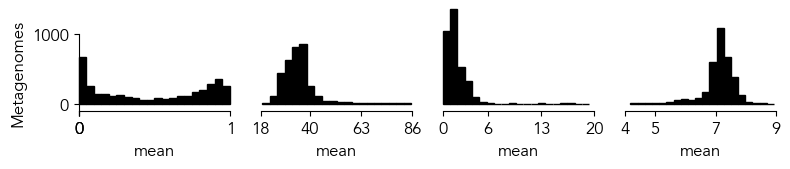

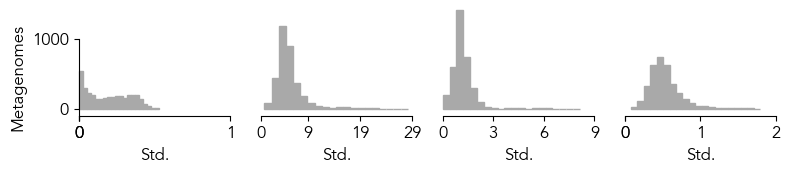

In [48]:
# Mean and standard deviation across all genomes 

PLOT_BOUNDS = {
    "temperature": (10, 105),
    "ph": (3, 9),
    "salinity": (0, 20),
    "oxygen": (0, 1),
}

fig, axes = plt.subplots(1,4, figsize=(9,1),gridspec_kw={'width_ratios' : (2, 2,2,2)})
for n, target in enumerate(targets):
    ax = axes[n]
    X = means_df[target]
    ax.hist(X, bins=20, color='black', edgecolor='black', clip_on=False)
    xmin = np.floor(X.min())
    xmax = np.ceil(X.max())
    xticks = [int(x) for x in np.linspace(xmin, xmax, 4)]
    ax.set_xticks(xticks)
    ax.set_xlim([xmin, xmax])
    ax.set_xlabel('mean')
    #ax.set_xlim(PLOT_BOUNDS[target.replace('_optimum', '')])
    #ax.set_xticks(ax.get_xticks())
    ax.set_ylim([-100,1000])
    ax.set_yticks([0,1000])
    if n == 0:
        ax.set_ylabel('Metagenomes')
    else:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)


fig, axes = plt.subplots(1,4, figsize=(9,1),gridspec_kw={'width_ratios' : (2, 2,2,2)})
for n, target in enumerate(targets):
    ax = axes[n]
    #X = means_df[target]
    X_error = stds_df[target]
    ax.hist(X_error, bins=20, color='darkgray', edgecolor='darkgray', clip_on=False)
    xmin = np.floor(X_error.min())
    xmax = np.ceil(X_error.max())
    xticks = [int(x) for x in np.linspace(xmin, xmax, 4)]
    ax.set_xticks(xticks)
    ax.set_xlim([xmin, xmax])
    ax.set_xlabel('Std.')
    #ax.set_xlim(PLOT_BOUNDS[target.replace('_optimum', '')])
    #ax.set_xticks(ax.get_xticks())
    ax.set_ylim([-100,1000])
    ax.set_yticks([0,1000])
    if n == 0:
        ax.set_ylabel('Metagenomes')
    else:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

In [49]:
(maxs_df - mins_df ).describe()

target,oxygen,ph_optimum,salinity_optimum,temperature_optimum
count,3407.000000,3407.000000,3407.000000,3407.000000
mean,0.547979,1.734379,3.482825,17.694270
std,0.368693,0.789460,1.919372,9.722442
min,0.000097,0.212168,0.000000,1.643890
25%,0.160882,1.193699,2.361067,11.698299
50%,0.622127,1.616094,3.245148,15.528712
75%,0.927348,2.115082,4.270081,20.554156
max,0.999549,7.735497,19.426834,81.791219


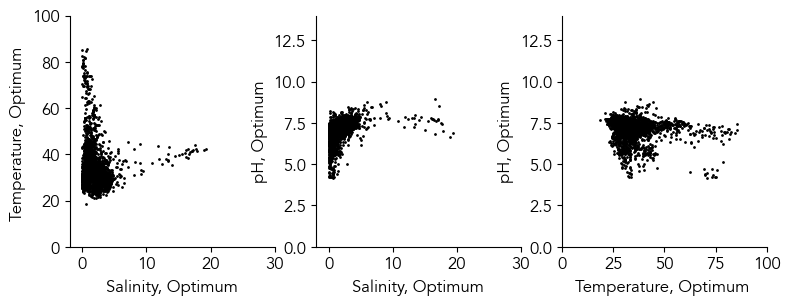

In [66]:
# Correlation across conditions
from itertools import combinations
optima_vars = ['salinity_optimum', 'temperature_optimum', 'ph_optimum']

limits = {'salinity_optimum' : [-2,30],
          'temperature_optimum' : [0,100],
          'ph_optimum' : [0,14]
         }

combinations = [(x, y) for x, y in combinations(optima_vars, 2)]
fig, axes = plt.subplots(1,3, figsize=( 3*len(combinations), 3))

for n, (x, y) in enumerate(combinations):

    X = means_df[f"{x}"].values
    Y = means_df[f"{y}"].values

    ax = axes[n]
    ax.scatter(X,Y, s=1)
    ax.set_xlabel(plot_formats[x])
    ax.set_ylabel(plot_formats[y])
    ax.set_xlim(limits[x])
    ax.set_ylim(limits[y])

In [67]:
# Organize by clustering within each biome
# by average conditions across genomes
sorted_within_biomes = []
biome2_labels_indices = {}
biome_order = []
for biome1 in ['Aquatic', 'Terrestrial', 'Host-associated', 'Engineered'][::-1]:
    biome1_df = genome_metadata_df[genome_metadata_df['biome1'] == biome1]
    for biome2 in biome1_df['biome2'].value_counts().index.tolist()[::-1]:
        
        if biome1 in ignore_biomes or biome2 in ignore_biomes:
            pass
        else:
            biome_order.append((biome1, biome2))
            biome2_indices = biome1_df.loc[biome1_df['biome2'] == biome2, 'metagenome_id'].drop_duplicates().tolist()
            subset_zscores = zscores_df.reindex(biome2_indices).dropna()
            if len(subset_zscores) > 1:
                biome_sorted_indices = cluster_by_metagenome_mean(subset_zscores, algorithm='ward')
            else:
                biome_sorted_indices = subset_zscores.index.tolist()
            
            if len(biome_sorted_indices) >= 5:
                print(biome1, biome2, len(biome_sorted_indices))
                idx1 = len(sorted_within_biomes)
                idx2 = idx1 + len(biome_sorted_indices)
                biome2_name = f"{biome2} (n={idx2-idx1})"
                biome2_labels_indices[biome2_name] = (idx1, idx2)
                sorted_within_biomes.extend(biome_sorted_indices)

Engineered Landfill 7
Engineered Built environment 95
Engineered Wastewater 115
Engineered Other engineered 172
Host-associated Algae 13
Host-associated Fungi 21
Host-associated Plants 103
Host-associated Invertebrates 85
Host-associated Vertebrates 1257
Terrestrial Deep subsurface 32
Terrestrial Soil 171
Aquatic Thermal springs 55
Aquatic Non-marine Saline and Alkaline 126
Aquatic Freshwater 403
Aquatic Marine 694


array([<Axes: title={'center': 'Oxygen'}, xlabel='Mean\nProb.'>,
       <Axes: title={'center': 'Temperature'}, xlabel='Mean\n°C'>,
       <Axes: title={'center': 'Salinity'}, xlabel='Mean\n% NaCl'>,
       <Axes: title={'center': 'pH'}, xlabel='Mean\npH'>], dtype=object)

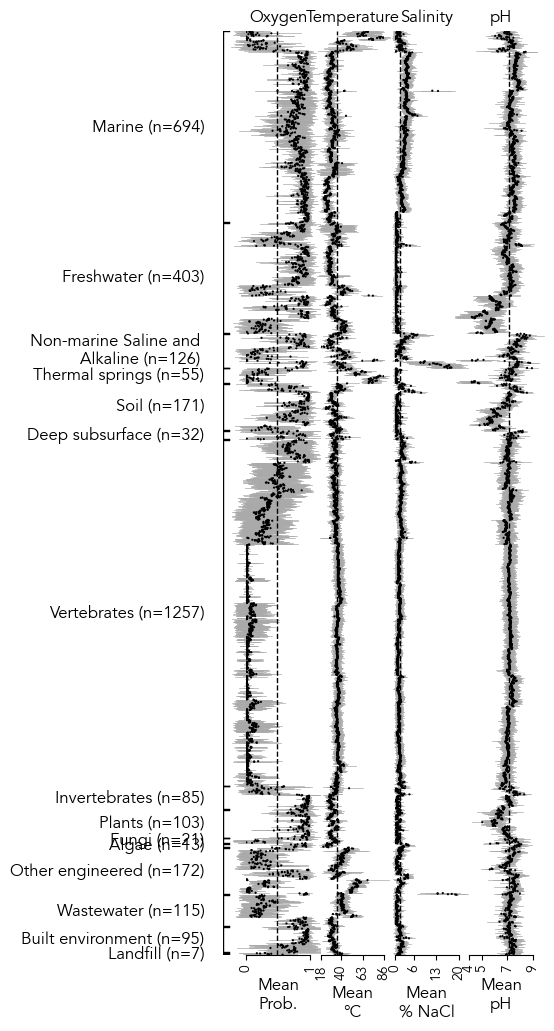

In [68]:
# Plot means and stdev subplots
highlight_indices = []
def get_nice_bounds(X):
    xmin = np.floor(X.min())
    xmax = np.ceil(X.max())
    xticks = [int(x) for x in np.linspace(xmin, xmax, 4)]
    return xticks
    
def ax_labeled(ax, labels, highlight_indices : list):
    pad = 1
    for label, (y1, y2) in labels.items():
        ax.plot([1, 0, 0, 1],[y1+pad, y1+pad, y2-pad, y2-pad], lw=1, c='black')
        ax.set_xlim([0,2])
        ax.text(s=newline_if_long(label, pad_newlines=5), va='center', ha='right', y=(y1+y2)/2, x=0)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)
        ax.set_yticks([])
        ax.set_ylim([-0.5,len(indices)+0.5])
        ax.spines['left'].set_visible(False)
    for i, y in enumerate(highlight_indices):
        ax.text(x=-3, y=y, s=f"{i+1}", color='black', fontsize=8, va='center', ha='left')
        ax.scatter([-1], [y], marker=">", s=20, edgecolor='None', facecolor='black', clip_on=False)

def axes_line_plots(axes, indices, plot_type='mean', color_by_bin=True, lw=0.5, ms=10, axvline=True):
    line_color = 'black'
    linestyle = '--'
    for n, target in enumerate(targets):
        ax = axes[n]
        ax.set_xlabel(f"Mean\n{units[target.replace('_optimum','')]}")
        X = means_df.loc[indices, target].values
        X_error = stds_df.loc[indices, target].values
        Y = range(len(indices))
        if color_by_bin is True:
            bins = bin_definitions[target]
            cmap = cmap_definitions[target]
            X[X < bins[0]] = bins[0]
            X_binned = np.digitize(X, bins) / (len(bins)+1)
            C = [cmap(i) for i in X_binned]
        else:
            C = ['black'] * len(X)
        
        if plot_type == 'mean':
            ax.scatter(X, Y, s=ms, marker=',', facecolor=C, edgecolor='None')
            ax.set_xlim([X.min(), X.max()])
            if axvline:
                ax.axvline(X.mean(), lw=lw, c=line_color, linestyle=linestyle)
        if plot_type == 'errorbars':
            ax.scatter(X, Y, s=ms, marker='.', facecolor=C, edgecolor='None', alpha=1,zorder=50)
            for x, y, xerr, c in zip(X, Y, X_error, C):
                ax.plot([x-xerr, x+xerr], [y,y], color='darkgray', lw=lw, zorder=0, clip_on=False)
    
            ax.set_xlim([X.min(), X.max()])
            if axvline:
                ax.axvline(X.mean(), lw=1, c=line_color, linestyle=linestyle)
        if plot_type == 'only_error':
            ax.scatter(X_error, Y, s=ms, marker=',', edgecolor='None')
            ax.set_xlim([X_error.min(), X_error.max()])
    
        ax.set_title(plot_formats[target.replace('_optimum', '')].replace(' Tolerance', ''))#, rotation=45, ha='left')
        if target != 'oxygen':
            xticks = get_nice_bounds(X)
            ax.set_xticks(xticks)
            ax.set_xlim([min(xticks), max(xticks)])
        else:
            ax.set_xticks([0,1])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90,size=10)
    for ax in axes:
        ax.set_yticks([])
        ax.set_ylim([-0.5,len(indices)+0.5])
        ax.spines['left'].set_visible(False)
    return axes

indices = sorted_within_biomes
labels = biome2_labels_indices

fig, axes = plt.subplots(1,5, figsize=(4,12), gridspec_kw={'width_ratios' : (0.2, 1,1,1,1)})
ax_labeled(axes[0], labels, highlight_indices)
axes_line_plots(axes[1:], indices, plot_type='errorbars', color_by_bin=False)

In [69]:
# Compute distribution by target
def distribution_df_by_target(target):
    sers = []
    bins = bin_definitions[target]
    for name, group in genome_metadata_df.groupby(['biome1', 'biome2', 'habitat']):
        for metagenome_id, group in group.groupby('metagenome_id'):
            genome_ids = group['genome_id'].tolist()
            binned_ser = histogram_by_values(optima_df, genome_ids, target, bins)
            binned_ser.name = metagenome_id
            sers.append(binned_ser)
    
    n_bins = len(bins) 
    blank_ser = pd.Series(dict(zip(range(1, n_bins + 1), [0] * n_bins)))
    blank_ser.name = -1
    sers.append(blank_ser)
    
    dist_df = pd.DataFrame(sers).fillna(0).drop(-1)
    dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = dist_df.T.sort_index().T
    return dist_df
    
dist_dfs = []
for target in targets:
    dist_df = distribution_df_by_target(target)
    bins = bin_definitions[target]
    if target in ['oxygen', ]:
        dist_df.columns = ['Intolerant', 'Tolerant']
    else:
        dist_df.columns = [f"{i}-{j}" for i,j in zip(bins, bins[1:])] + [f">{bins[-1]}"]
    dist_dfs.append(dist_df)

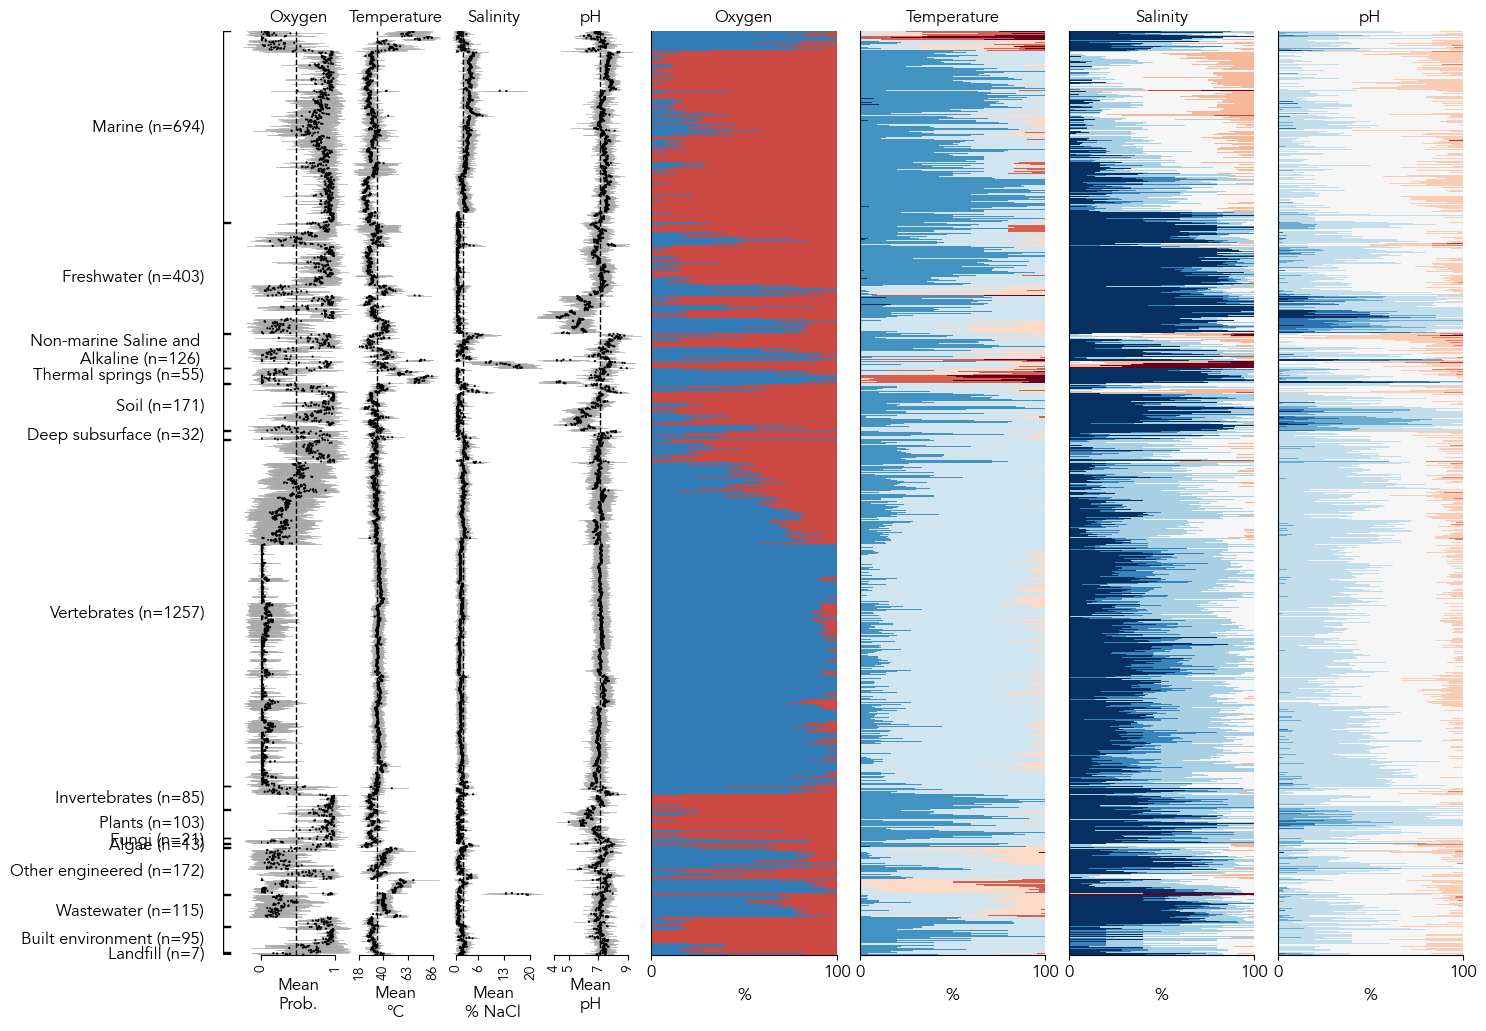

In [70]:
# Plot main figure
fig, axes = plt.subplots(1,9, figsize=(16,12),gridspec_kw={'width_ratios' : (0.4, 2,2,2,2,5,5,5,5,)})
axl = axes.flatten()

# means and stdevs
ax_labeled(axes[0], labels, highlight_indices)
axes_line_plots(axes[1:5], indices, plot_type='errorbars', color_by_bin=False)

# barplots
for n, target in enumerate(['oxygen',  'temperature_optimum', 'salinity_optimum', 'ph_optimum']):
    dist_df = dist_dfs[n]
    ax = axes[n+5]
    if target in  ['oxygen']:
        if target == 'oxygen':
            cmap = oxygen_cmap
    else:
        cmap = 'RdBu_r'
    (100 * dist_df.loc[indices]).plot.barh(ax=ax, stacked=True, cmap=cmap, edgecolor='None', width=1, legend=False)
    ax.set_title(plot_formats[target.replace('_optimum', '')].replace(' Tolerance', ''))
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([0, 100])
    ax.set_xlim([0, 100])
    ax.set_xlabel('%')
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False)

plt.savefig("fig-4a.svg",  format="svg")
plt.show()

## Lookup some stats

In [73]:
query_mids = means_df[means_df['salinity_optimum'] > 6].index
#query_mids = means_df[means_df['ph_optimum'] < 5].index
#print(len(query_mids)/ len(indices), len(indices))
genome_metadata_df[genome_metadata_df['metagenome_id'].isin(query_mids)].drop_duplicates(subset=['metagenome_id'])[['biome2']].value_counts().to_frame().sort_index() / len(query_mids)

,count
biome2,
Marine,0.106383
Non-marine Saline and Alkaline,0.659574
Other engineered,0.148936
Soil,0.063830
Vertebrates,0.021277


In [72]:

query_mids = genome_metadata_df[genome_metadata_df['biome2'] == 'Thermal springs']['metagenome_id'].drop_duplicates().tolist()
#query_mids = genome_metadata_df[(genome_metadata_df['biome2'] == 'Marine') & (genome_metadata_df['habitat'].str.contains('thermal'))]['metagenome_id'].drop_duplicates().tolist()
# query_mids = genome_metadata_df[(genome_metadata_df['biome2'] == 'Non-marine Saline and Alkaline') 
# & ((genome_metadata_df['habitat'].str.contains('Hypersaline')) 
#    | (genome_metadata_df['habitat'].str.contains('Hypersaline')) )]['metagenome_id'].drop_duplicates().tolist()

query_mids = genome_metadata_df[(genome_metadata_df['biome2'] == 'Vertebrates')]['metagenome_id'].drop_duplicates().tolist()
means_df.reindex(query_mids).dropna().describe(percentiles=np.array([0, 5, 25,50,75,95,100])/100)

target,oxygen,ph_optimum,salinity_optimum,temperature_optimum
count,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.166339,7.109580,1.486272,35.556585
std,0.228130,0.177166,0.551140,2.072222
min,0.000050,6.449820,0.328567,28.011575
0%,0.000050,6.449820,0.328567,28.011575
5%,0.003000,6.827729,0.811827,32.028982
25%,0.010620,7.000607,1.125319,34.313562
50%,0.056130,7.103531,1.368468,35.656786
75%,0.253819,7.214655,1.783026,36.942234
95%,0.677829,7.401808,2.406576,38.754885


In [56]:
diffs_df.describe(percentiles=np.array([0, 5, 25,50,75,95,100])/100)

target,oxygen,ph_optimum,salinity_optimum,temperature_optimum
count,3407.000000,3407.000000,3407.000000,3407.000000
mean,0.547979,1.734379,3.482825,17.694270
std,0.368693,0.789460,1.919372,9.722442
min,0.000097,0.212168,0.000000,1.643890
0%,0.000097,0.212168,0.000000,1.643890
5%,0.025810,0.706782,0.981612,6.824360
25%,0.160882,1.193699,2.361067,11.698299
50%,0.622127,1.616094,3.245148,15.528712
75%,0.927348,2.115082,4.270081,20.554156
95%,0.988540,3.176749,6.354455,37.770734


In [57]:
query_mids = means_df[means_df['ph_optimum'] < 5].index
print(len(query_mids)/ len(indices), len(indices))
genome_metadata_df[genome_metadata_df['metagenome_id'].isin(query_mids)].drop_duplicates(subset=['metagenome_id'])[['habitat']].value_counts().to_frame().sort_index() / len(query_mids)

0.01015228426395939 3349


,count
habitat,
Arctic peat soil,0.029412
Bog,0.088235
Ferrous mat,0.029412
Ferrous microbial mat,0.029412
Ferrous microbial mat and aquatic,0.029412
Freshwater,0.470588
Hot spring,0.264706
Hypersaline mat,0.029412
Peatland,0.029412


# Individual Genomes in Metagenomes

In [124]:
req_n_genomes = 20
biome2_to_selection = {}
for i, (biome1, biome2) in enumerate(biome_order[::-1]):
    biome2_df = genome_metadata_df[genome_metadata_df['biome2'] == biome2].set_index('metagenome_id')
    metagenome_id = np.abs(biome2_df.index.value_counts() - req_n_genomes).idxmin()
    n_genomes = biome2_df.index.value_counts().loc[metagenome_id]
    if n_genomes > (req_n_genomes - 5) and n_genomes < (req_n_genomes + 5):
        biome2_to_selection[biome2] = metagenome_id

biome2_to_selection

{'Marine': 3300012950,
 'Freshwater': 3300020219,
 'Non-marine Saline and Alkaline': 3300025603,
 'Thermal springs': 3300026278,
 'Soil': 3300025600,
 'Deep subsurface': 3300025536,
 'Cave': 3300019458,
 'Vertebrates': 3300007295,
 'Invertebrates': 3300010882,
 'Plants': 3300025913,
 'Algae': 3300027498,
 'Other engineered': 3300001594,
 'Wastewater': 3300028625,
 'Landfill': 3300014204}

In [125]:
metagenome_id = 3300025913
metagenome_id = 3300012950
genome_metadata_df[genome_metadata_df['metagenome_id'] == metagenome_id].iloc[0].T

genome_id                                                  3300012950_8
metagenome_id                                                3300012950
genome_length                                                   4451891
num_contigs                                                         340
n50                                                               17957
num_16s                                                             1.0
num_5s                                                              0.0
num_23s                                                             1.0
num_trna                                                           45.0
completeness                                                      96.17
contamination                                                      3.76
quality_score                                                     77.37
mimag_quality                                                        MQ
otu_id                                                         O

In [126]:
metagenome_df['phylum']

,phylum,phylum
26798,Planctomycetota,p__Planctomycetota
26799,Planctomycetota,p__Planctomycetota
26800,Verrucomicrobiota,p__Verrucomicrobiota
26801,Planctomycetota,p__Planctomycetota
26802,Actinobacteriota,p__Actinobacteriota
26803,Thermoplasmatota,p__Thermoplasmatota
26804,Patescibacteria,p__Patescibacteria
26805,Acidobacteriota,p__Acidobacteriota
26806,Gemmatimonadota,p__Gemmatimonadota
26807,Actinobacteriota,p__Actinobacteriota


In [127]:
metagenome_df = genome_metadata_df[genome_metadata_df['metagenome_id'] == metagenome_id].copy()
taxonomy = pd.DataFrame(metagenome_df['taxstring'].astype(str).str.split(';').tolist())
taxlevels = ['domain', 'phylum', 'class','order','family','genus','species']
taxonomy.columns = taxlevels
taxonomy.index = metagenome_df.index
metagenome_df = pd.concat([metagenome_df, taxonomy], axis=1)
metagenome_df['phylum'].value_counts()
genome_ids = metagenome_df['genome_id'].tolist()

habitat = metagenome_df.iloc[0].loc['habitat']

genome_data = optima_df.reindex(genome_ids)
metagenome_zscores_df = ((genome_data - genome_data.mean(axis=0)) / genome_data.std(axis=0))
metagenome_sorted_indices = cluster_by_metagenome_mean(metagenome_zscores_df.dropna()[targets], algorithm='ward')
metagenome_sorted_indices
C = []

genome_data = genome_data.loc[metagenome_sorted_indices]
for target in targets:
    bins = bin_definitions[target]
    X = genome_data[target].values
    X[X < bins[0]] = bins[0]
    ones = np.array([1] * len(X))
    X_binned = np.digitize(X, bins) / (len(bins)+1)
    C.append(X_binned)
    
targets,  C

(['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum'],
 [array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.66666667,
         0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
         0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
         0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
  array([0.57142857, 0.42857143, 0.42857143, 0.42857143, 0.42857143,
         0.28571429, 0.28571429, 0.28571429, 0.42857143, 0.28571429,
         0.28571429, 0.42857143, 0.28571429, 0.28571429, 0.42857143,
         0.42857143, 0.42857143, 0.42857143, 0.42857143, 0.28571429]),
  array([0.625, 0.5  , 0.5  , 0.375, 0.5  , 0.5  , 0.5  , 0.5  , 0.375,
         0.5  , 0.5  , 0.5  , 0.375, 0.625, 0.5  , 0.5  , 0.625, 0.5  ,
         0.625, 0.625]),
  array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6,
         0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.5])])

In [128]:
genome_data

target,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum
3300012950_67,0.178129,8.059548,5.091789,7.154755,9.656294,1.722075,5.359744,54.249046,33.820717,46.858412
3300012950_15,0.264094,9.764126,5.599874,7.745587,8.216163,1.472027,3.561342,41.393115,15.031628,33.702713
3300012950_77,0.050764,9.044747,5.937921,7.641414,9.202635,0.000000,3.561652,39.816765,25.549402,33.731367
3300012950_26,0.450881,8.457293,5.599331,7.072274,6.734625,1.349044,2.203594,38.192227,15.797565,32.137456
3300012950_36,0.566864,8.917983,5.645834,7.380476,9.116968,1.155629,3.066432,41.556608,18.602934,35.135328
3300012950_38,0.861302,8.534046,5.198246,7.031587,10.278396,2.219294,3.571748,32.937421,6.637233,26.512547
3300012950_6,0.902796,9.075796,5.451212,7.363840,6.755209,2.147587,2.975291,30.354641,10.435977,24.172815
3300012950_18,0.865573,9.877284,5.543647,7.559434,8.236489,0.210894,2.542764,36.924522,5.199743,26.473391
3300012950_74,0.868304,8.937542,5.463332,7.716518,8.988759,0.000000,1.463895,36.184431,9.810903,31.096112
3300012950_8,0.618710,9.743085,6.116314,7.831647,8.172971,2.519128,3.052648,34.458829,11.937416,28.201035


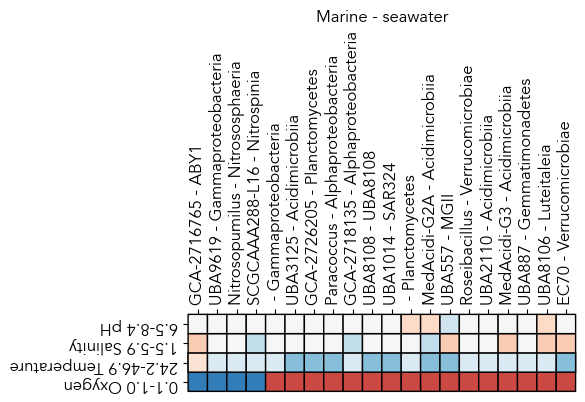

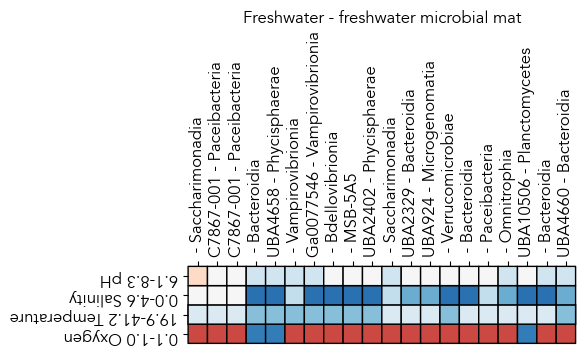

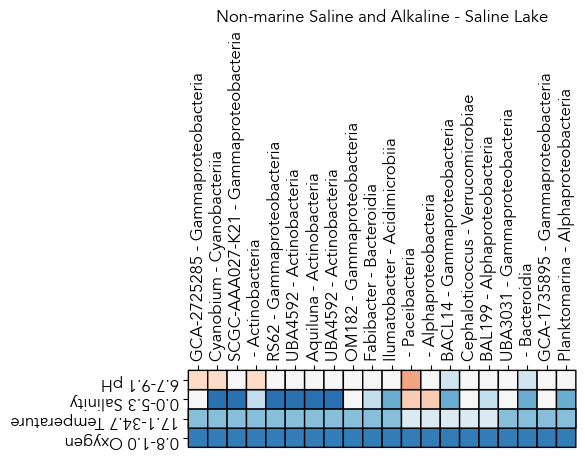

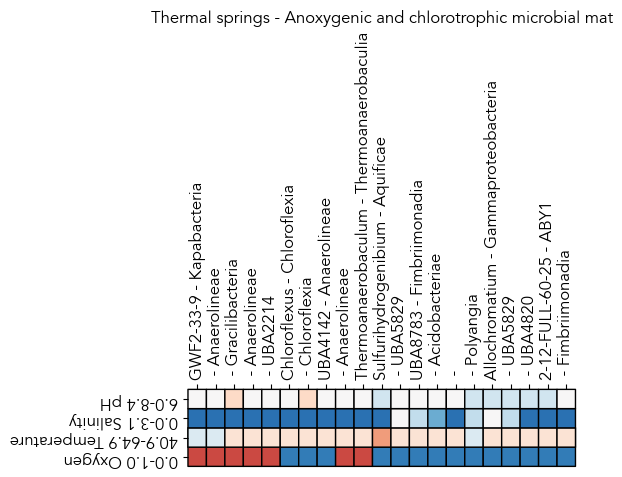

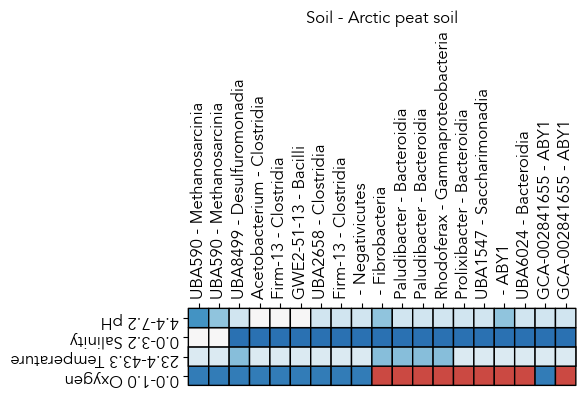

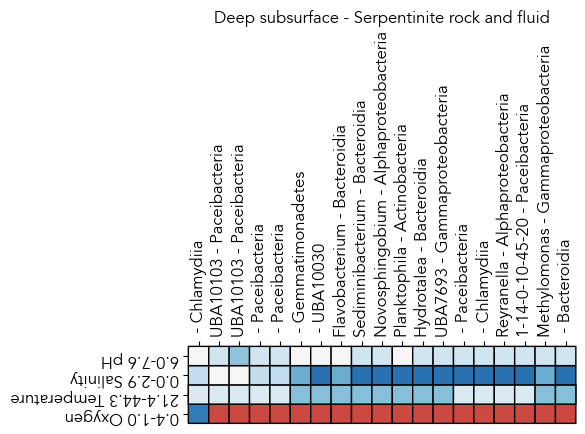

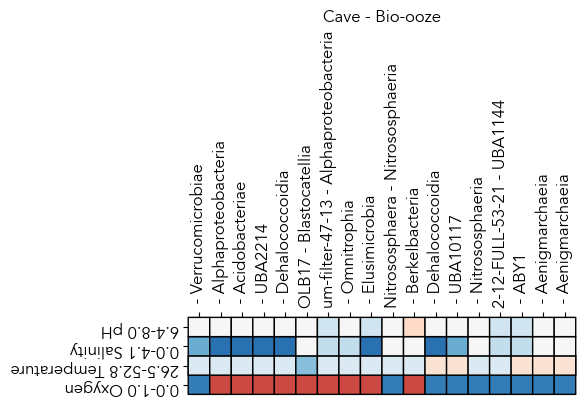

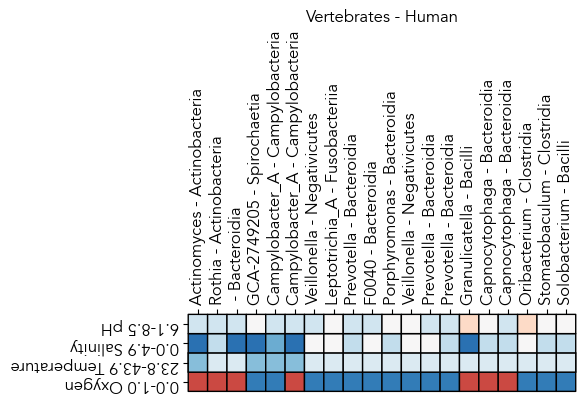

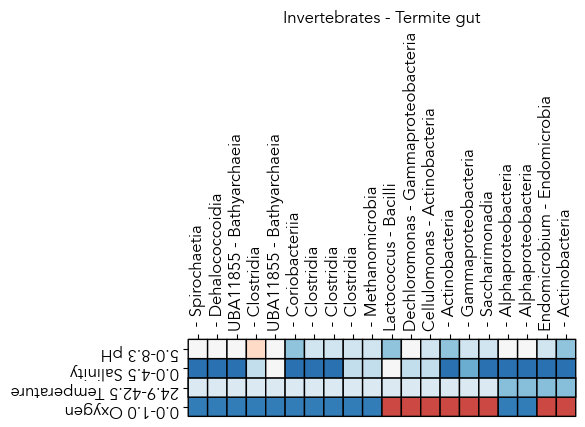

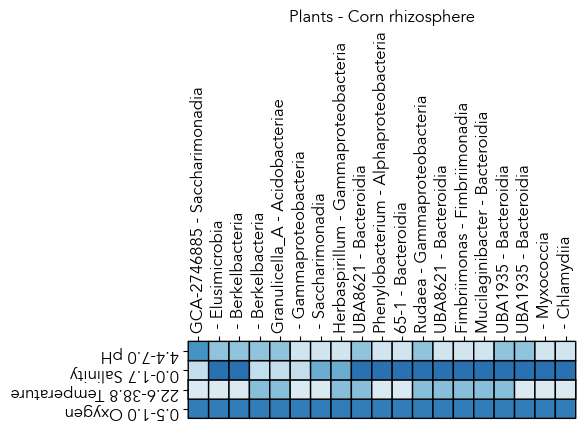

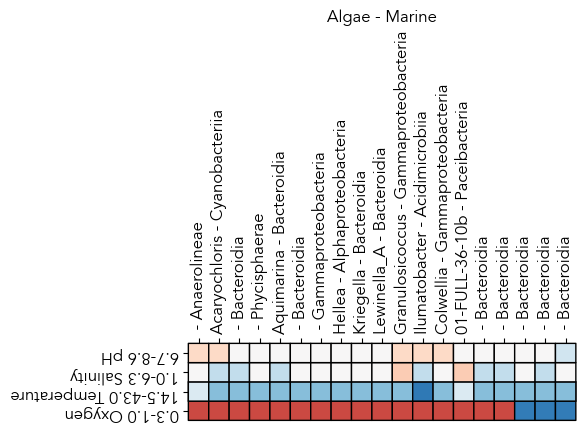

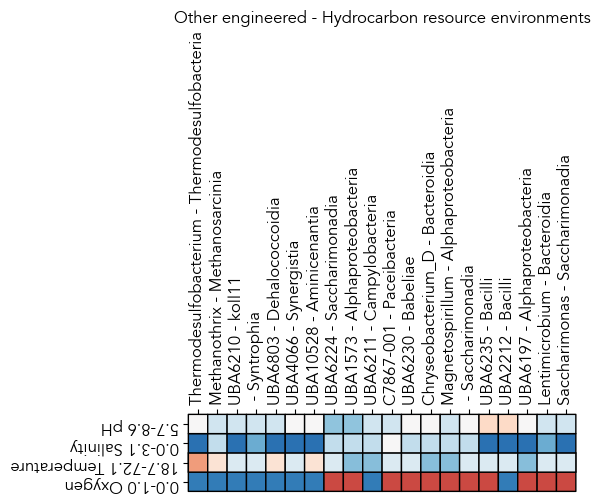

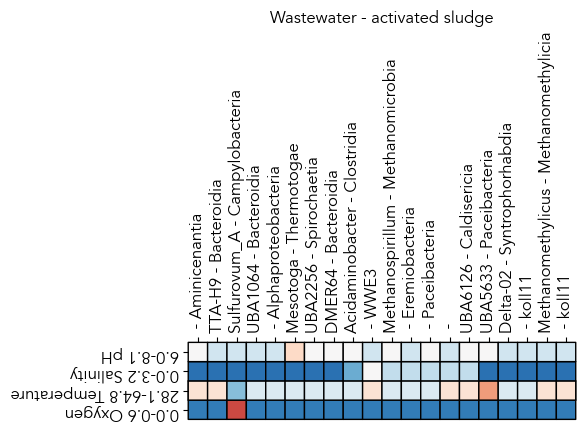

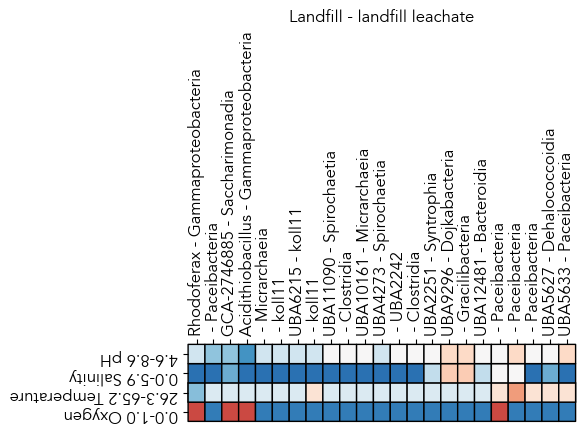

In [129]:
for n, (biome, metagenome_id) in enumerate(biome2_to_selection.items()):

    metagenome_df = genome_metadata_df.loc[genome_metadata_df['metagenome_id'] == metagenome_id].copy()
    taxonomy = pd.DataFrame(metagenome_df['taxstring'].str.split(';').tolist())
    taxonomy.columns = ['domain', 'phylum','class','order','family','genus','species']
    taxonomy.index = metagenome_df.index
    metagenome_df = pd.concat([metagenome_df, taxonomy], axis=1)
    metagenome_df['phylum'].value_counts()
    genome_ids = metagenome_df['genome_id'].tolist()

    habitat = metagenome_df.iloc[0].loc['habitat']

    genome_data = optima_df.reindex(genome_ids)
    metagenome_zscores_df = ((genome_data - genome_data.mean(axis=0)) / genome_data.std(axis=0))
    metagenome_sorted_indices = cluster_by_metagenome_mean(metagenome_zscores_df.dropna()[targets], algorithm='ward')
    metagenome_sorted_indices
    C = []
    genome_data = genome_data.loc[metagenome_sorted_indices]

    target_min_max = {}
    for target in targets:
        bins = bin_definitions[target]
        X = genome_data[target].values
        
        X[X < bins[0]] = bins[0]
        target_min_max[target] = (np.min(X), np.max(X))
        ones = np.array([1] * len(X))
        X_binned = np.digitize(X, bins) / (len(bins)+1)
        C.append(X_binned)

    genome_taxa = genome_metadata_df.set_index('genome_id').loc[genome_data.index, 'taxstring'].str.split(';', expand=True)

    # Optional to print
    taxa = (genome_taxa[5] + ' - ' + genome_taxa[2]).tolist()
    taxa = [taxon.replace('c__', '').replace('g__', '') for taxon in taxa]
    # print()
    # print(n, biome)
    # print()
    # print('Genus')
    # for taxon in taxa[::-1]:
    #     t = taxon.split(' - ')[0]
    #     if t:
    #         print(t)
    #     else:
    #         print('-')
    # print('Class')
    # for taxon in taxa[::-1]:
    #     print(taxon.split(' - ')[1])

    
    fig, ax = plt.subplots(figsize=(5,1))
    ax.pcolor(range(len(C[0])), [0,2], [C[0], C[0]], cmap=oxygen_cmap, edgecolor='black', lw=1,clip_on=False)#, edgecolor='black')#, edgecolor='white', lw=0.05)
    ax.pcolor(range(len(C[0])), [2,4,6], C[1:], cmap='RdBu_r', edgecolor='black', lw=1,clip_on=False, vmin=0,vmax=1)#,edgecolor='black')#, edgecolor='white', lw=0.05)
    ax.set_yticks([i for i in range(8) if i % 2 == 0])

    labels = [f"{target_min_max[target][0]:.1f}-{target_min_max[target][1]:.1f}"  + ' ' + plot_formats[target.split('_')[0]].replace(' Tolerance', '') for target in targets]
    ax.set_yticklabels(labels, rotation=180)#, rotation=155,va='bottom')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticks(range(len(C[0])))
    ax.set_xticklabels(taxa, rotation=90)#,ha='right')
    ax.set_title(biome + ' - ' + habitat)
    ax.xaxis.tick_top()

    plt.savefig(f"fig-4c-{n}.svg",  format="svg")
    plt.show()

In [130]:
genome_metadata_df.iloc[0].T

genome_id                                                  3300025516_6
metagenome_id                                                3300025516
genome_length                                                   2910752
num_contigs                                                         137
n50                                                               34707
num_16s                                                             1.0
num_5s                                                              1.0
num_23s                                                             1.0
num_trna                                                           43.0
completeness                                                      90.42
contamination                                                      0.65
quality_score                                                     87.17
mimag_quality                                                        HQ
otu_id                                                         O

# Individual Metagenomes

In [131]:
req_n_genomes = 30
biome2_to_selection = {}
for i, (biome1, biome2) in enumerate(biome_order[::-1]):
    biome2_df = genome_metadata_df[genome_metadata_df['biome2'] == biome2].set_index('metagenome_id')
    metagenome_id = biome2_df.index.value_counts().index[0]
    biome2_to_selection[biome2] = metagenome_id
    #metagenome_id = np.abs(biome2_df.index.value_counts() - req_n_genomes).idxmin()
    # n_genomes = biome2_df.index.value_counts().loc[metagenome_id]
    # if n_genomes > (req_n_genomes - 5) and n_genomes < (req_n_genomes + 5):
    #     biome2_to_selection[biome2] = metagenome_id

biome2_to_selection['Marine'] = 3300027607 # not subsurface or sediment
biome2_to_selection

{'Marine': 3300027607,
 'Freshwater': 3300013137,
 'Non-marine Saline and Alkaline': 3300027784,
 'Thermal springs': 3300027863,
 'Sediment': 3300027898,
 'Soil': 3300005529,
 'Deep subsurface': 3300027276,
 'Peat': 3300023088,
 'Plant litter': 3300022911,
 'Cave': 3300019458,
 'Vertebrates': 3300018878,
 'Invertebrates': 3300010167,
 'Plants': 3300025913,
 'Fungi': 3300012090,
 'Algae': 3300027509,
 'Other engineered': 3300026311,
 'Wastewater': 3300025737,
 'Built environment': 3300011904,
 'Landfill': 3300015214}

In [132]:
show = genome_metadata_df[genome_metadata_df['biome2'] == 'Invertebrates'].set_index('metagenome_id').index.value_counts().index

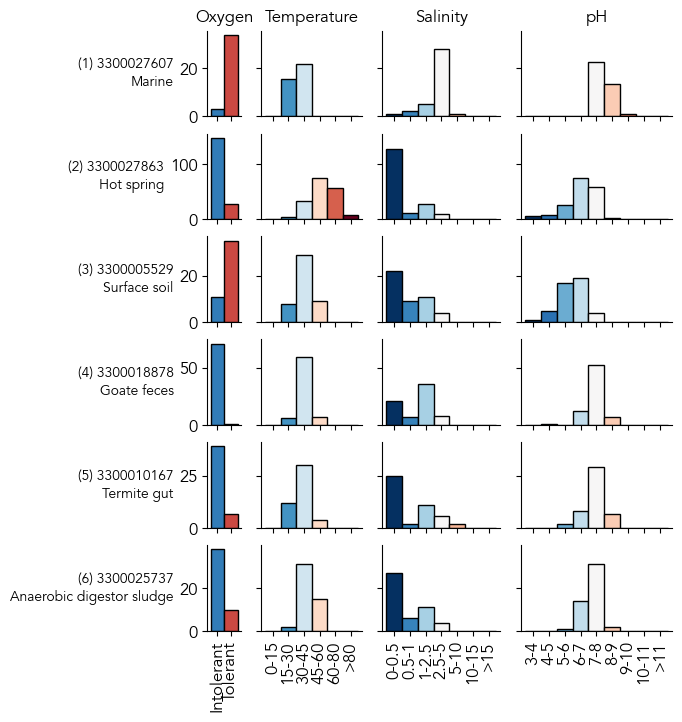

In [133]:
import matplotlib
biomes_to_show = ['Marine', 'Thermal springs', 'Soil', 'Vertebrates', 'Invertebrates', 'Wastewater']
#nrows = len(highlighted_metagenome_ids)
#nrows = len(biome2_to_selection.keys())
nrows = len(biomes_to_show)
ncols = 4
fig, axes = plt.subplots(nrows,ncols,figsize=(6,1.3*nrows),gridspec_kw={'width_ratios' : [len(df.columns) for df in dist_dfs]})

highlighted_metagenome_ids = []
for i, biome2 in enumerate(biomes_to_show):
    metagenome_id = biome2_to_selection[biome2]
    highlighted_metagenome_ids.append(metagenome_id)
#for i, (biome2, metagenome_id) in enumerate(biome2_to_selection.items()):
# for i, (biome1, biome2) in enumerate(biome_order[::-1]):
    #biome2_df = genome_metadata_df[genome_metadata_df['biome2'] == biome2].set_index('metagenome_id')
    #metagenome_id = biome2_df.index.value_counts().index[0]
#     #metagenome_metadata = biome2_df.loc[metagenome_id]
#for i, metagenome_id in enumerate(highlighted_metagenome_ids):
    metagenome_metadata = genome_metadata_df.loc[genome_metadata_df['metagenome_id'] == metagenome_id]
    n_genomes = len(metagenome_metadata)
    descriptors = metagenome_metadata[['habitat']].iloc[0].tolist()
    cmap = matplotlib.colormaps.get_cmap('RdBu_r')

    subaxes = axes[i, :]
    for n, dist_df in enumerate(dist_dfs):
        target_type = targets[n].split('_')[0]
        ax = subaxes[n]
        if n == 0:
            colors = oxygen_colors
        else:
            colors = [cmap(i) for i in np.linspace(0, 1, len(dist_df.columns))]

        
        
        #ser = 100 * dist_df.loc[metagenome_id]
        ser = n_genomes * dist_df.loc[metagenome_id]
        ser.plot.bar(ax=ax, color=colors, width=1, edgecolor='black')
        #ax.set_xlabel('\n'.join(targets[n].split('_')))
        # if n == 0:
        #     ax.set_title(f"Metagenome #{1+i}: {metagenome_id} ({', '.join(descriptors)})\n{target_type}", ha='left')
        # else:
        #     ax.set_title(target_type)
        if i == 0:
            ax.set_title(plot_formats[target_type.replace('_optimum', '')].replace(' Tolerance', ''))
        if i < nrows - 1:
            ax.set_xticklabels([])

        if n == 0:
            #print(' - '.join(descriptors))
            description = newline_if_long(text=' - '.join(descriptors))
            ax.set_ylabel(f"({1+i}) {metagenome_id}\n{description}", 
                          ha='right', rotation=0, va='center', fontsize=10)
        if n > 0:
            ax.set_yticklabels([])
            #ax.spines['left'].set_visible(False)
    ymax = 0
    for ax in subaxes:
        ymax = max([ymax, ax.get_ylim()[1]])
    for ax in subaxes:
        ax.set_ylim([0, ymax])
    
    
    #axes[0].set_ylabel('# MAGs')
    #print(metagenome_id)

Text(0, 0.5, '#')

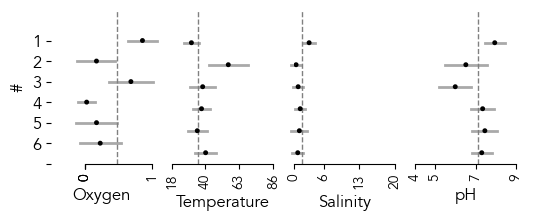

In [134]:
from matplotlib import ticker
#fig, axes = plt.subplots(1, n_cols,figsize=(6,1),gridspec_kw={'width_ratios' : [len(df.columns) for df in dist_dfs]})
fig, axes = plt.subplots(1, 4,figsize=(6,2))

plot_indices = [biome2_to_selection[i] for i in biomes_to_show][::-1]
#plot_indices = list(biome2_to_selection.values())[::-1]
#plot_indices = highlighted_metagenome_ids[::-1]
axes_line_plots(axes, plot_indices, plot_type='errorbars', color_by_bin=False, lw=2, ms=50, axvline=False)
axes[0].set_yticks(range(-1, nrows))
axes[0].set_yticklabels([''] + list(range(1,1+nrows))[::-1])


for target, ax in zip(targets, axes):
    X = means_df.loc[indices, target].values
    ax.axvline(X.mean(), linestyle='--', color='gray')
    xticks = get_nice_bounds(X)
    ax.set_xticks(xticks)
    ax.set_xlim([min(xticks), max(xticks)])
    ax.set_xticklabels(xticks)
    ax.set_title('')
    ax.set_xlabel(plot_formats[target.replace('_optimum', '')].replace(' Tolerance', ''))

#axes[0].xaxis.set_major_locator(ticker.MultipleLocator(base=1))
axes[0].set_xlim([-0.5, 1])
axes[0].spines['bottom'].set_bounds([0, 1])

#axes[0].set_xticks([0,1])
#axes[0].set_ylabel('Metagenome #', ha='right', rotation=0, va='center')
axes[0].set_ylabel('#')
#ax.yaxis.*?

# Useless Data Exploration with t-SNE

In [137]:
X = optima_df.dropna().values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn.manifold import TSNE
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)

X_tsne = t_sne.fit_transform(X_scaled)
X_tsne.shape

(52462, 2)

In [138]:
tsne_df = optima_df.dropna().copy()
tsne_df['dim1'] = X_tsne[:, 0]
tsne_df['dim2'] = X_tsne[:, 1]
tsne_df['biome1'] = tsne_df.index.map(dict(genome_metadata_df[['genome_id', 'biome1']].values))
tsne_df['biome2'] = tsne_df.index.map(dict(genome_metadata_df[['genome_id', 'biome2']].values))
tsne_df['habitat'] = tsne_df.index.map(dict(genome_metadata_df[['genome_id', 'habitat']].values))

tsne_df

target,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum,dim1,dim2,biome1,biome2,habitat
3300025640_35,0.957532,9.943997,5.349265,7.478552,3.086731,0.000000,0.000000,29.689803,9.418584,23.889203,0.283624,3.610989,Aquatic,Marine,Pelagic marine
3300012847_11,0.971758,8.605819,5.361243,6.928523,2.098983,0.000000,0.000000,35.370597,10.782845,27.788790,1.328861,2.875189,Host-associated,Invertebrates,insecta
3300008660_3,0.067940,9.413505,6.477551,7.807200,9.667497,0.649015,3.946863,40.870916,11.782698,30.327258,-0.879099,-2.829674,Host-associated,Vertebrates,Human
3300007802_42,0.005884,8.294718,4.394675,6.525067,5.614853,0.757281,0.096314,46.380725,22.769516,38.978341,1.501605,-1.045570,Host-associated,Vertebrates,Human
3300020477_45,0.959607,9.722181,6.083280,7.835349,13.628693,1.404875,5.320082,40.785372,13.885410,33.285136,-2.628818,1.475284,Aquatic,Marine,Marine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300012956_46,0.929395,7.923302,5.051979,6.420187,0.815621,0.000000,0.074804,35.108727,9.021477,25.644973,2.141771,2.461591,Engineered,Wastewater,active sludge
3300012141_10,0.874945,6.955952,5.162601,6.034278,3.979429,0.000000,0.000000,35.650781,7.378633,26.336488,2.321707,1.872219,Host-associated,Fungi,Attine ant fungus gardens
3300025664_18,0.968611,8.727471,4.727015,6.675384,2.938051,0.000000,0.000000,33.215491,7.770932,24.808351,1.749302,2.865380,Terrestrial,Soil,Arctic peat soil
3300025209_1,0.965617,9.763698,5.383612,7.554462,6.263653,0.000000,1.033302,32.021521,10.088294,24.087998,-0.775667,3.501729,Aquatic,Marine,Deep ocean


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


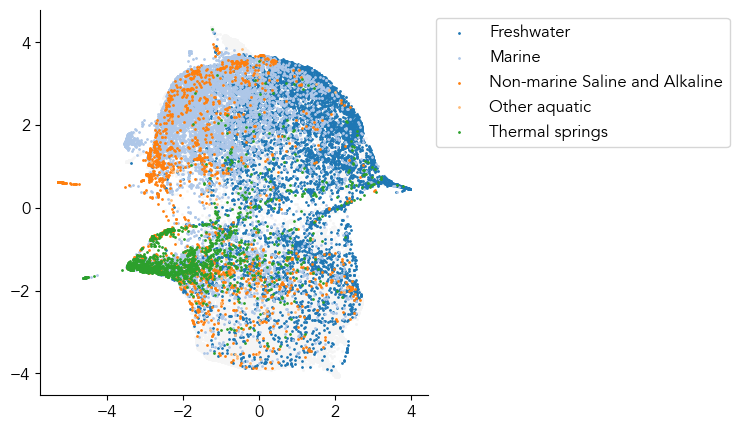

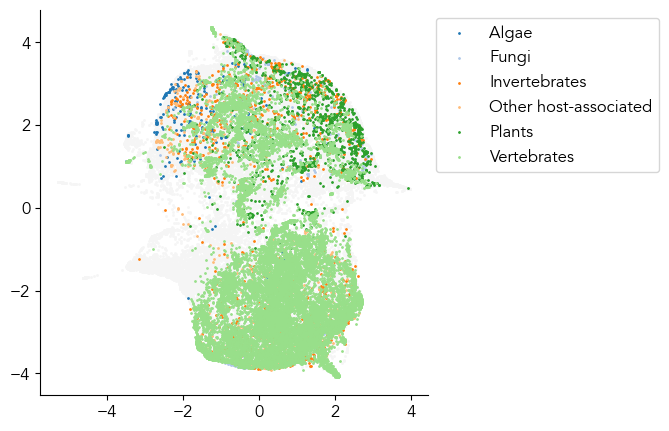

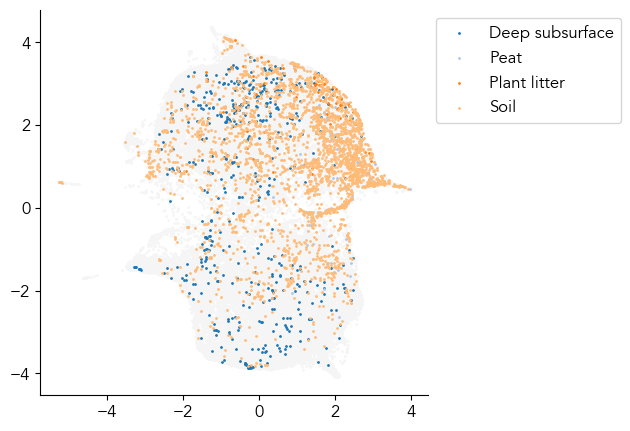

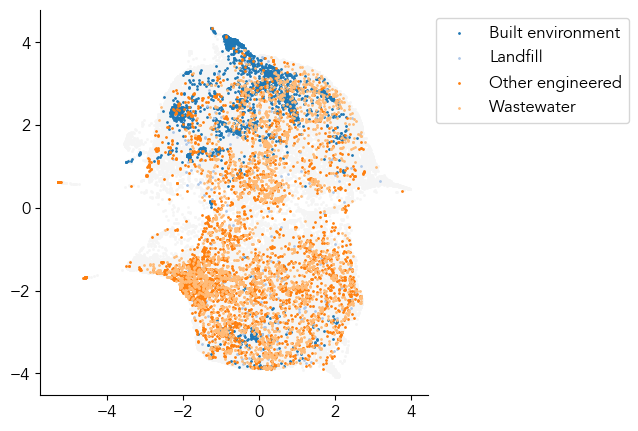

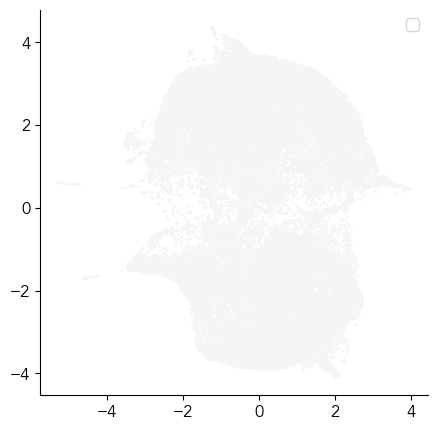

In [139]:
cmap = plt.get_cmap("tab20")

for biome in tsne_df['biome1'].drop_duplicates():
    fig, ax = plt.subplots(figsize=(5,5))
    is_in_biome = (tsne_df['biome1'] == biome)
    ax.scatter(tsne_df[~is_in_biome]['dim1'], tsne_df[~is_in_biome]['dim2'], s=1, color='whitesmoke')
    i = 0
    for name, group in tsne_df[is_in_biome].groupby('biome2'):
        if len(group) > 50:
            ax.scatter(group['dim1'], group['dim2'], s=1, color=cmap(i), label=name)
            i += 1
    ax.legend(bbox_to_anchor=(1,1))

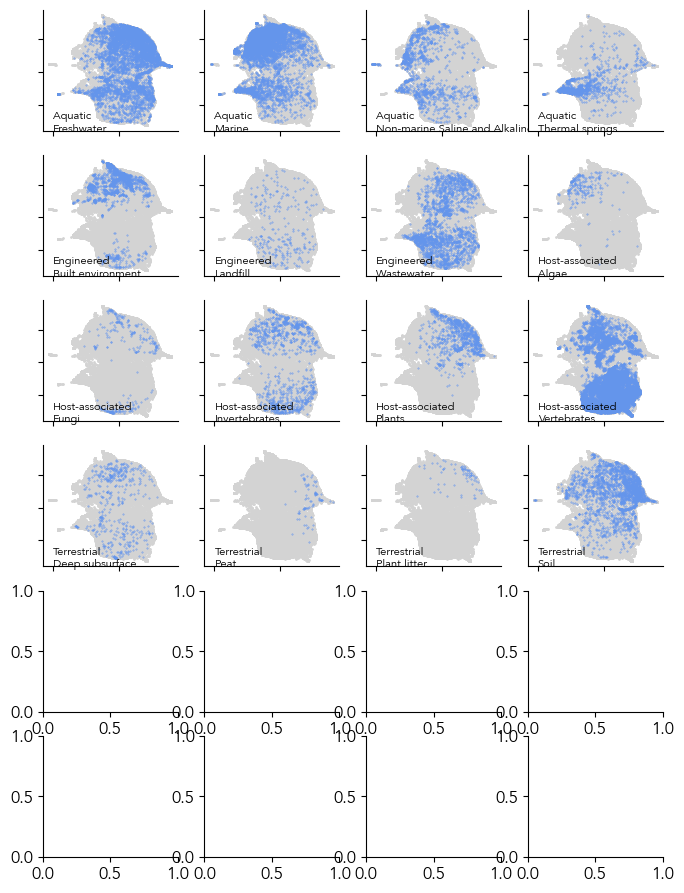

In [140]:
cmap = plt.get_cmap("tab20")

fig, axes = plt.subplots(6,4,figsize=(8,11))
axl = axes.flatten()
n = 0

for name, group in tsne_df.groupby(['biome1', 'biome2']):    
    #is_in_biome = (tsne_df['biome1'] == biome)
    
    if len(group) > 50 and n < (axes.shape[0] * axes.shape[1]) and not (name[1].startswith('Other')):
        ax = axl[n]
        #print(n)
        ax.scatter(tsne_df['dim1'], tsne_df['dim2'], s=1, color='lightgray')    
        ax.scatter(group['dim1'], group['dim2'], s=0.5, marker='.', alpha=1, color='cornflowerblue',)
        label = '\n'.join(name)
        ax.text(x=-5,y=-3,s=label,fontsize=8, va='top')
        #ax.set_title(name)
        #ax.legend()
        n += 1
        ax.set_yticklabels([])
        ax.set_xticklabels([])
#ax.legend(bbox_to_anchor=(1,1))
#plt.tight_layout()